# 导入必要模块

In [1]:
import os
import torch
import time
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import data_processing as dp
from model import PhysicsInformedNN

%matplotlib inline
np.random.seed(1234)
torch.manual_seed(1234)
torch.autograd.set_detect_anomaly(True)
plt.rc('grid', color='k', alpha=0.2)
current_path = os.getcwd()
try:
    plt.ion()
    plt.rc('font', family='Times New Roman')
    plt.rc('text', usetex=True)
except Exception as e:
    warnings.warn(e.msg, UserWarning)

# 设置参数，加载数据

========  Using device  ========
============  cuda  ============
====== Data Loading Done! ======


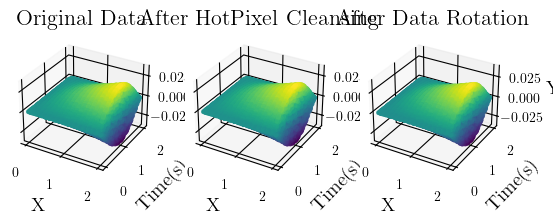

In [2]:
# Configuration
epochs = 30000
layers = [2, 50, 50, 50, 50, 1]
connections = [0, 1, 0, 1, 0, 1]
USE_pth = False
# Check CUDA availability (for GPU acceleration)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("========  Using device  ========")
print(f"============  {device}  ============")

# Load Data
option = 'npz'
filename = 'variables.npz'
# filename = 'test16-1.mat'
# filename = 'dvSave-2023_03_26_02_21_16.npy'
Timestamp, xEvent, yEvent, polarities = dp.load_data('npz', current_path, filename)
# Data Cleansing
fig = plt.figure()
dp.plot_data(
    fig.add_subplot(131, projection='3d'),
    xEvent, Timestamp, yEvent,
    title='Original Data', color=yEvent
)
(xEvent, Timestamp, yEvent, polarities) = dp.HotPixel_cleansing(xEvent, Timestamp, yEvent, polarities)
dp.plot_data(
    fig.add_subplot(132, projection='3d'),
    xEvent, Timestamp, yEvent,
    title='After HotPixel Cleansing', color=yEvent
)
(xEvent, Timestamp, yEvent) = dp.data_rotate(xEvent, Timestamp, yEvent, option='TLS')
dp.plot_data(
    fig.add_subplot(133, projection='3d'),
    xEvent, Timestamp, yEvent,
    title='After Data Rotation', color=yEvent
)

# Convert to torch.Tensor
xEvent = torch.tensor(
    xEvent, dtype=torch.float32,
    device=device, requires_grad=True
).unsqueeze(1)
Timestamp = torch.tensor(
    Timestamp, dtype=torch.float32,
    device=device, requires_grad=True
).unsqueeze(1)
yEvent = torch.tensor(
    yEvent, dtype=torch.float32,
    device=device, requires_grad=True
).unsqueeze(1)
print('====== Data Loading Done! ======')

# 初始化模型

In [3]:
print('===== Model Initialization =====')
pinn = PhysicsInformedNN(
    layers, connections, device,
    xEvent, Timestamp, yEvent,
    epochs
)
print(pinn.dnn)

===== Model Initialization =====
DNN(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (tanh): Tanh()
)


# 是否加载已有权重

In [13]:
USE_pth = True
os.makedirs(os.path.join(current_path, 'data', 'pth'), exist_ok=True)
if USE_pth:
    try:
        loss_list = [
            i[:-4].split('_')
            for i in os.listdir(
                os.path.join(
                    current_path,
                    'data', 'pth'
                )
            )
        ]
        def compare(x):
            Ymd = x[1].split('.')
            HMS = x[2].split('.')
            t = time.mktime(
                time.strptime(
                    ''.join([*Ymd, *HMS]),
                    '%Y%m%d%H%M%S'
                )
            )
            return t
        state_dic = torch.load(
            os.path.join(
                current_path,
                'data', 'pth',
                '_'.join(max(loss_list, key=compare)) + '.pth'
            )
        )
        pinn.load(state_dic)
        print('Model weights loaded!')
    except Exception as e:
        print('Failed to load model weights!\nError Info:', e)
print('========= Model Training =======')

Model weights loaded!
========= Model Training =======


# 训练模型

In [ ]:
# Training the Model
start_time = time.time()
pinn.train()
pinn.save(os.path.join(current_path, 'data', 'pth'), 'state')
end_time = time.time()
print('==============================================')
print('============= Model Training Done! ===========')
print("======== Training time: {:.2f} seconds ======".format(end_time - start_time))
print('=== Average time per epoch: {:.4f} seconds ==='.format((end_time - start_time) / epochs))
print('==============================================')

# 呈现结果

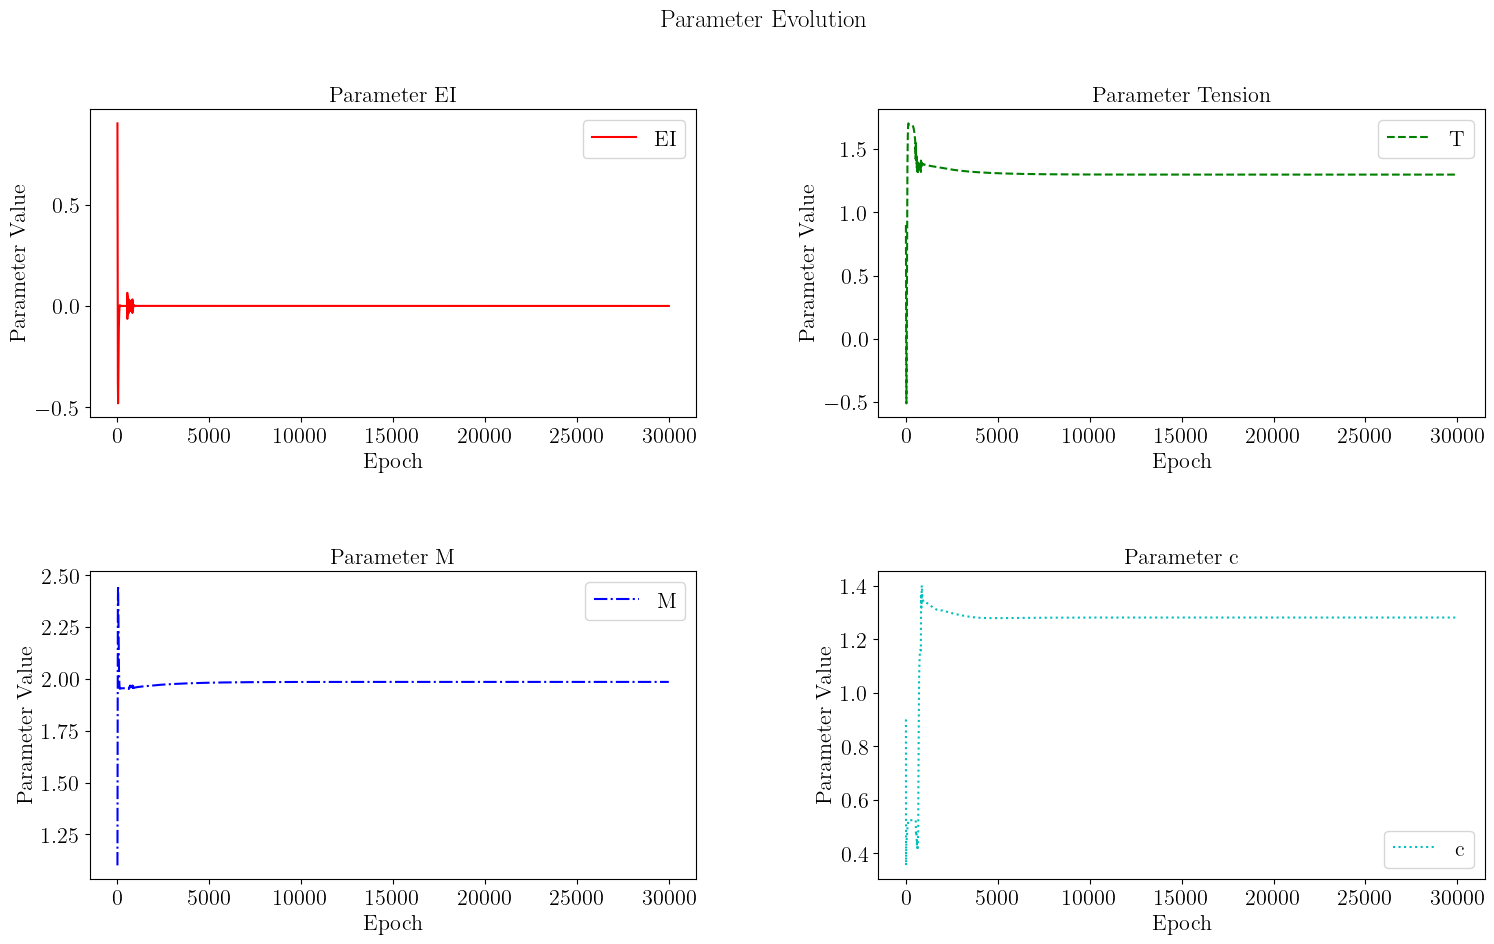

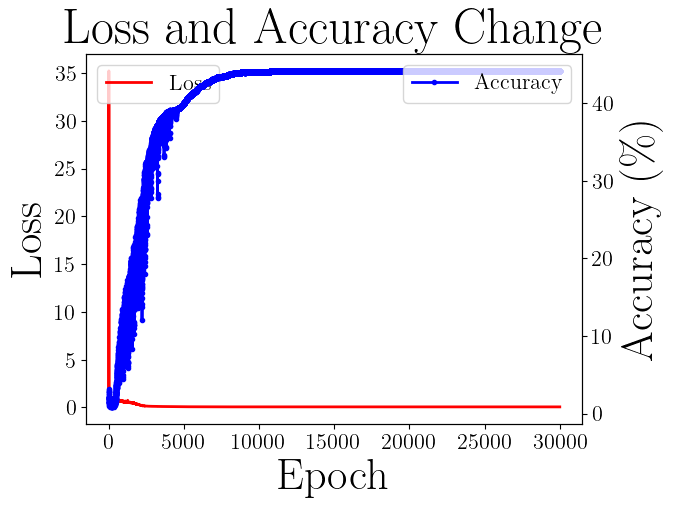

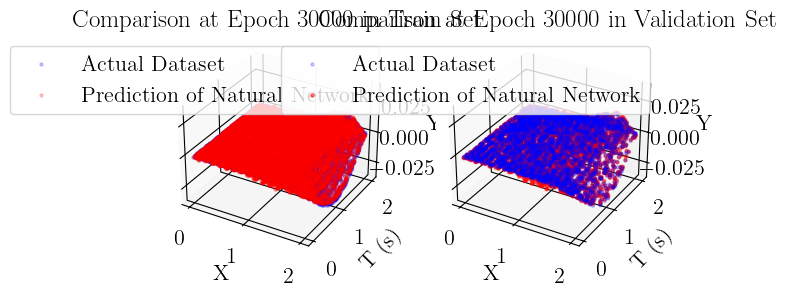

In [14]:
dp.draw_results(pinn)